### prep

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv('spells.csv')

df['num_components'] = (df['verbal_component'].astype(int) + 
                        df['somatic_component'].astype(int) + 
                        df['material_component'].astype(int))

def convert_range(r):
    if pd.isna(r):
        return np.nan
    r = r.lower().strip()
    if 'feet' in r:
        return float(r.replace('feet', '').strip())
    elif r == 'self' or r == 'touch':
        return 0  # self/touch = 0 feet
    elif r == 'sight' or 'mile' in r:
        return 1000  # arbitrary val for sight/miles
    else:
        return np.nan # others as nan

df['range_numeric'] = df['range'].apply(convert_range)

df_clean = df.dropna(subset=['range_numeric'])

### scatter - level vs. range

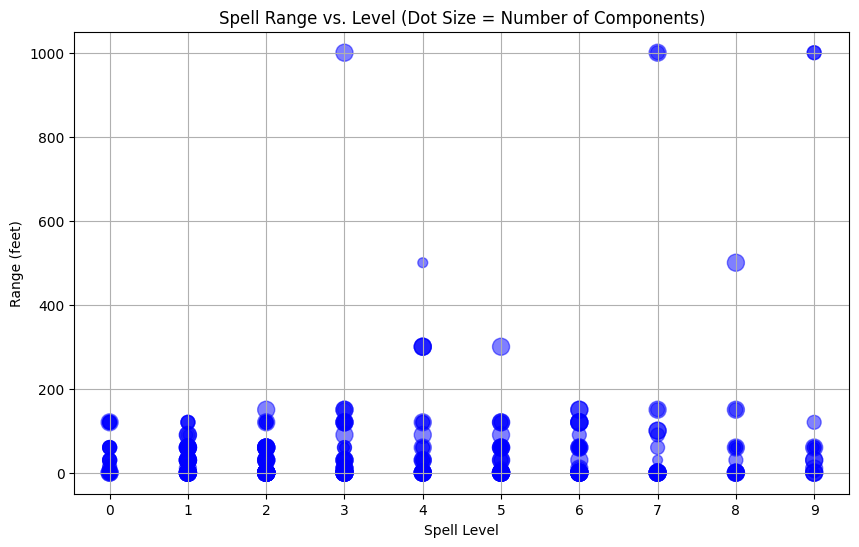

In [3]:
plt.figure(figsize=(10, 6))
plt.scatter(df_clean['level'], df_clean['range_numeric'], 
            s=df_clean['num_components'] * 50,  # size by number of components
            alpha=0.5, c='blue')
plt.xlabel('Spell Level')
plt.ylabel('Range (feet)')
plt.title('Spell Range vs. Level (Dot Size = Number of Components)')
plt.xticks(range(0, 10))  # levels 0-9
plt.grid(True)
plt.show()

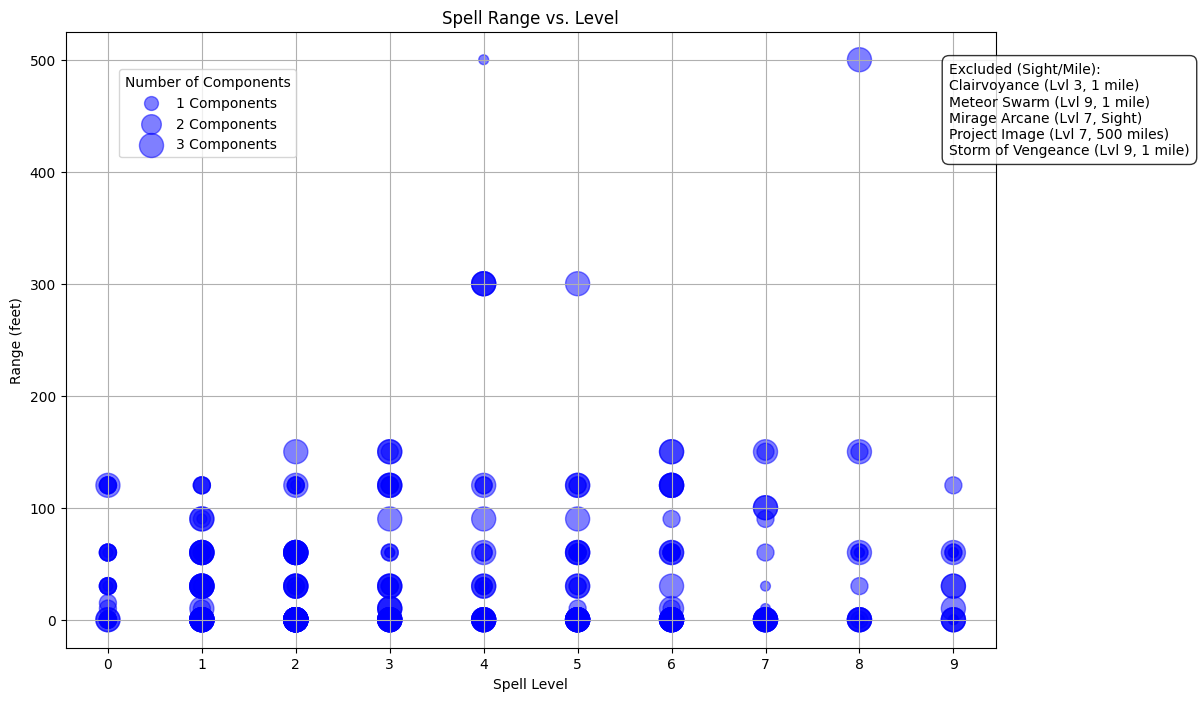

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# exclude sight/mile
df_excluded = df_clean[df_clean['range_numeric'] == 1000]
df_clean_filtered = df_clean[df_clean['range_numeric'] != 1000]

# print("Spells with 1000 feet (excluded from scatter plot):")
# print(df_excluded[['name', 'level', 'range']].to_string(index=False))

size_map = {1: 50, 2: 150, 3: 300}
plt.figure(figsize=(12, 8))  
scatter = plt.scatter(df_clean_filtered['level'], df_clean_filtered['range_numeric'], 
                      s=df_clean_filtered['num_components'].map(size_map), 
                      alpha=0.5, c='blue') 


plt.xlabel('Spell Level')
plt.ylabel('Range (feet)')
plt.title('Spell Range vs. Level')
plt.xticks(range(0, 10))  # Levels 0-9
plt.grid(True)

excluded_text = "Excluded (Sight/Mile):\n" + "\n".join(
    f"{row['name']} (Lvl {row['level']}, {row['range']})" for _, row in df_excluded.iterrows()
)
plt.text(0.95, 0.95, excluded_text[:200], 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

sizes = [1, 2, 3]
legend_elements = [plt.scatter([], [], s=s * 100, label=f'{s} Components', c='blue', alpha=0.5) 
                   for s in sizes]
plt.legend(handles=legend_elements, title='Number of Components', 
           loc='upper left', bbox_to_anchor=(0.05, 0.95))

plt.show()

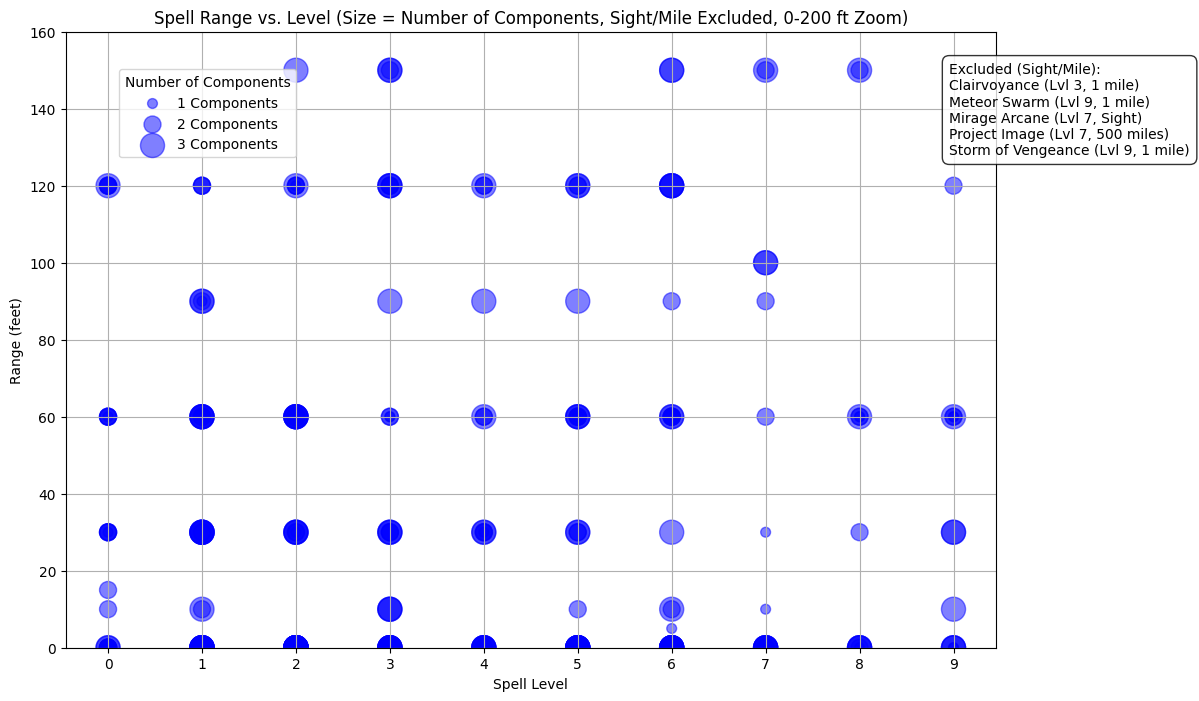

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

df_excluded = df_clean[df_clean['range_numeric'] == 1000]
df_clean_filtered = df_clean[df_clean['range_numeric'] != 1000]

# print("Spells with 1000 feet (excluded from scatter plot):")
# print(df_excluded[['name', 'level', 'range']].to_string(index=False))

size_map = {1: 50, 2: 150, 3: 300}
plt.figure(figsize=(12, 8)) 
scatter = plt.scatter(df_clean_filtered['level'], df_clean_filtered['range_numeric'], 
                      s=df_clean_filtered['num_components'].map(size_map),  
                      alpha=0.5, c='blue')

plt.xlabel('Spell Level')
plt.ylabel('Range (feet)')
plt.title('Spell Range vs. Level (Size = Number of Components, Sight/Mile Excluded, 0-200 ft Zoom)')
plt.xticks(range(0, 10))  # Levels 0-9
plt.ylim(0, 160)  # zoom
plt.grid(True)

excluded_text = "Excluded (Sight/Mile):\n" + "\n".join(
    f"{row['name']} (Lvl {row['level']}, {row['range']})" for _, row in df_excluded.iterrows()
)
plt.text(0.95, 0.95, excluded_text[:200], 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

sizes = [1, 2, 3]  
legend_elements = [plt.scatter([], [], s=size_map[s], label=f'{s} Components', c='blue', alpha=0.5) 
                   for s in sizes] 
plt.legend(handles=legend_elements, title='Number of Components', 
           loc='upper left', bbox_to_anchor=(0.05, 0.95))

plt.show()

<Figure size 1200x800 with 0 Axes>

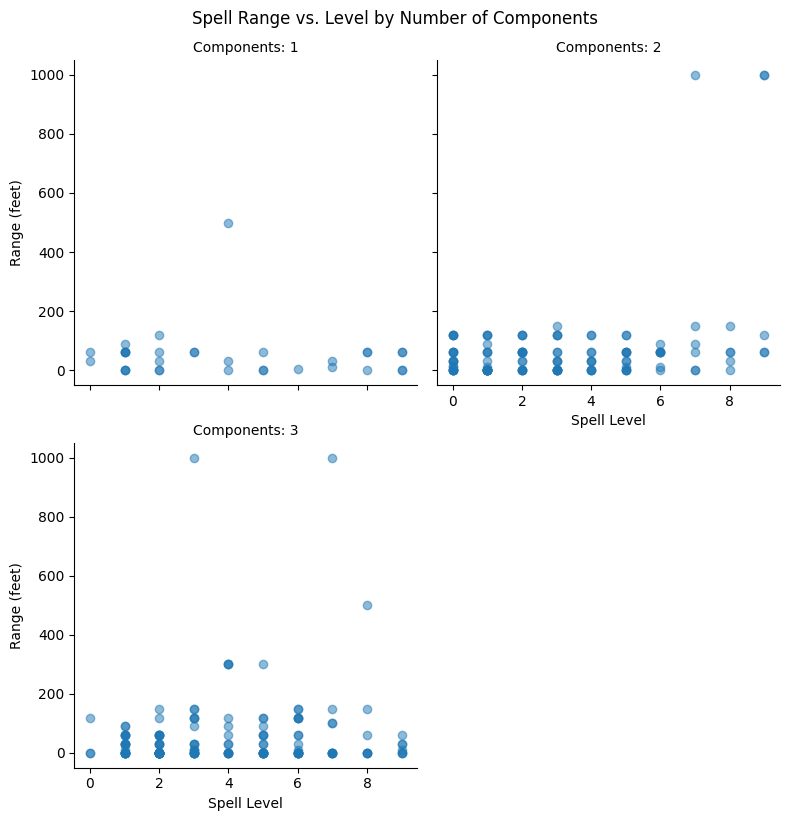

In [6]:
import seaborn as sns
plt.figure(figsize=(12, 8))
g = sns.FacetGrid(df_clean, col='num_components', col_wrap=2, height=4)
g.map(plt.scatter, 'level', 'range_numeric', alpha=0.5)
g.set_titles('Components: {col_name}')
g.set_axis_labels('Spell Level', 'Range (feet)')
plt.suptitle('Spell Range vs. Level by Number of Components', y=1.02)
plt.show()

### heat - level vs. combo vs. range

C:\Users\Hao\AppData\Local\Temp\ipykernel_18744\3649547217.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['component_combo'] = df_clean.apply(get_component_combo, axis=1)


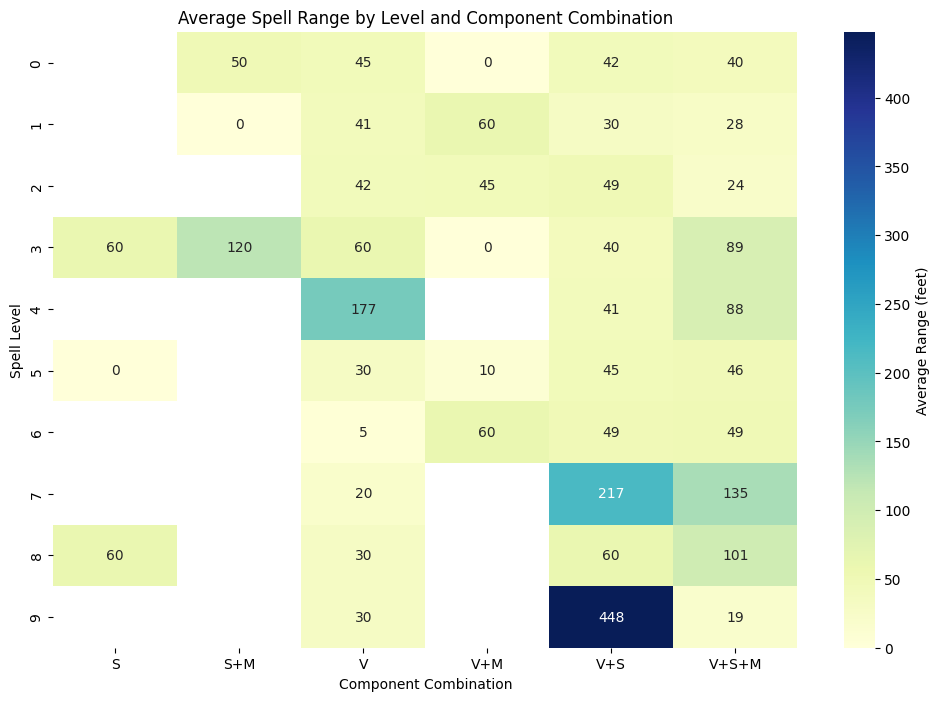

In [7]:
# heatmap

def get_component_combo(row):
    components = []
    if row['verbal_component']: components.append('V')
    if row['somatic_component']: components.append('S')
    if row['material_component']: components.append('M')
    return '+'.join(components) if components else 'None'

df_clean['component_combo'] = df_clean.apply(get_component_combo, axis=1)

pivot_table = pd.pivot_table(df_clean, values='range_numeric', 
                             index='level', columns='component_combo', 
                             aggfunc='mean')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt='.0f', cmap='YlGnBu', 
            cbar_kws={'label': 'Average Range (feet)'})
plt.title('Average Spell Range by Level and Component Combination')
plt.xlabel('Component Combination')
plt.ylabel('Spell Level')
plt.show()

In [8]:
import plotly.express as px
import pandas as pd

# hover info
df_clean['spell_info'] = df_clean['name'] + ': ' + df_clean['description'].str.slice(0, 50) + '...'
pivot_range = pd.pivot_table(df_clean, values='range_numeric', 
                             index='level', columns='component_combo', 
                             aggfunc='mean')
pivot_spells = pd.pivot_table(df_clean, values='spell_info', 
                              index='level', columns='component_combo', 
                              aggfunc=lambda x: '<br>'.join(x)) 

fig = px.imshow(pivot_range, 
                labels=dict(x='Component Combination', y='Spell Level', color='Avg Range (feet)'),
                title='Average Spell Range by Level and Component Combination')
fig.update_traces(hovertemplate='Level: %{y}<br>Combo: %{x}<br>Avg Range: %{z:.0f} feet<br>Spells:<br>%{customdata}',
                  customdata=pivot_spells.values)
fig.show()

C:\Users\Hao\AppData\Local\Temp\ipykernel_18744\2551193990.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['spell_info'] = df_clean['name'] + ': ' + df_clean['description'].str.slice(0, 50) + '...'


### trends

In [9]:
trend_data = df_clean.groupby(['level', 'num_components'])['range_numeric'].mean().reset_index()

print("Average Range by Spell Level and Number of Components:")
print(trend_data)

Average Range by Spell Level and Number of Components:
    level  num_components  range_numeric
0       0               1      45.000000
1       0               2      41.190476
2       0               3      40.000000
3       1               1      41.250000
4       1               2      30.454545
5       1               3      27.916667
6       2               1      42.000000
7       2               2      48.750000
8       2               3      24.193548
9       3               1      60.000000
10      3               2      42.352941
11      3               3      89.047619
12      4               1     176.666667
13      4               2      40.909091
14      4               3      87.857143
15      5               1      20.000000
16      5               2      42.307692
17      5               3      45.789474
18      6               1       5.000000
19      6               2      50.000000
20      6               3      49.473684
21      7               1      20.000000
22

In [ ]:
for level in range(0, 10):
    level_data = trend_data[trend_data['level'] == level]
    if not level_data.empty:
        print(f"\nLevel {level}:")
        for _, row in level_data.iterrows():
            print(f"  {int(row['num_components'])} components: {row['range_numeric']:.0f} feet")

In [10]:
import plotly.graph_objects as go

trend_data = df_clean.groupby(['level', 'num_components'])['range_numeric'].mean().reset_index()
trend_data['count'] = df_clean.groupby(['level', 'num_components'])['range_numeric'].count().values

fig = go.Figure()
for num in range(1, 4):  # start at 1 component
    subset = trend_data[trend_data['num_components'] == num]
    if not subset.empty:
        fig.add_trace(go.Scatter(
            x=subset['level'], y=subset['range_numeric'], mode='lines+markers',
            name=f'{num} Components', 
            hovertemplate='Level: %{x}<br>Avg Range: %{y:.0f} feet<br>Spells: %{customdata}',
            customdata=subset['count']
        ))

fig.update_layout(
    title='Average Range by Level and Number of Components',
    xaxis_title='Spell Level', yaxis_title='Average Range (feet)',
    legend_title='Number of Components',
    xaxis=dict(tickmode='linear', tick0=0, dtick=1)
)
fig.show()

In [11]:
import plotly.graph_objects as go

trend_data = df_clean.groupby(['level', 'num_components']).agg(
    range_numeric=('range_numeric', 'mean'),
    spell_count=('name', 'count'),
    spell_names=('name', lambda x: '<br>'.join(x)) 
).reset_index()


fig = go.Figure()
for num in range(1, 4):
    subset = trend_data[trend_data['num_components'] == num]
    if not subset.empty:
        fig.add_trace(go.Scatter(
            x=subset['level'], y=subset['range_numeric'], mode='lines+markers',
            name=f'{num} Components',
            hovertemplate=(
                'Level: %{x}<br>'
                'Avg Range: %{y:.0f} feet<br>'
                'Spells: %{customdata[0]}<br>'
                '%{customdata[1]}'
            ),
            customdata=subset[['spell_count', 'spell_names']].values
        ))

fig.update_layout(
    title='Average Range by Level and Number of Components',
    xaxis_title='Spell Level', yaxis_title='Average Range (feet)',
    legend_title='Number of Components',
    xaxis=dict(tickmode='linear', tick0=0, dtick=1)
)
fig.show()